<a href="https://colab.research.google.com/github/iris-kurapaty/GradCam_Exp/blob/main/ERA_Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# !git clone https://github.com/iris-kurapaty/GradCam_Exp.git

In [2]:
%cd '/content/GradCam_Exp/src'

/content/GradCam_Exp/src


In [3]:
!pip install torch-lr-finder

In [4]:
!pip install grad-cam

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from torch_lr_finder import LRFinder
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
from transform import *
from model import *
from utils import *
from dataset import cifar10Dataset, get_loader
from mytrain import *
from mytest import test
from main import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [7]:
SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [8]:
train_transforms = get_train_transforms()
test_transforms = get_test_transforms()
train_data = cifar10Dataset('./data', train=True, download=True, transform=train_transforms) #
test_data = cifar10Dataset('./data', train=False, download=True, transform=test_transforms) #

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [9]:
# train dataloader and test loader
batch_size = 512
train_loader, test_loader = get_loader(train_data, test_data, batch_size, use_cuda)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model Params



In [10]:
from model import ResNet18

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


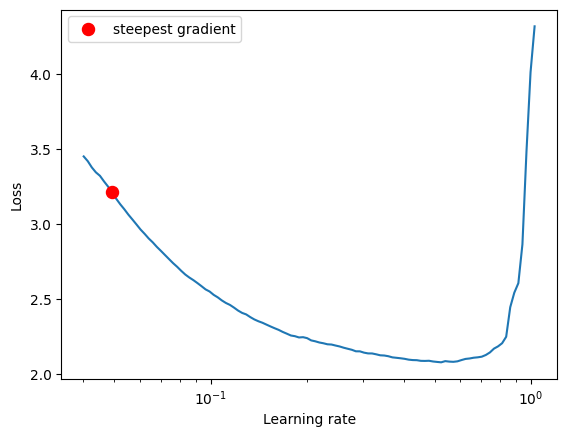

In [11]:
optimizer, criterion = get_lr_value(model, train_loader)

# Training and Testing

In [12]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []
lrs = []
EPOCHS = 20

scheduler = OneCycleLR(optimizer, max_lr=4.93E-02,steps_per_epoch=len(train_loader),
                       epochs=EPOCHS,pct_start=6/EPOCHS, div_factor=100, three_phase=False,
                       final_div_factor=100,anneal_strategy='linear')

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=1.4127907752990723 Batch_id=97 Accuracy=38.56: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0029, Accuracy: 4981/10000 (49.81%)

EPOCH: 1


Loss=1.2244020700454712 Batch_id=97 Accuracy=51.48: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.0032, Accuracy: 4766/10000 (47.66%)

EPOCH: 2


Loss=1.1602890491485596 Batch_id=97 Accuracy=57.59: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.0027, Accuracy: 5521/10000 (55.21%)

EPOCH: 3


Loss=1.0647683143615723 Batch_id=97 Accuracy=60.85: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0034, Accuracy: 4895/10000 (48.95%)

EPOCH: 4


Loss=1.0249013900756836 Batch_id=97 Accuracy=62.19: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.0073, Accuracy: 3145/10000 (31.45%)

EPOCH: 5


Loss=0.9056004285812378 Batch_id=97 Accuracy=62.92: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.0031, Accuracy: 5317/10000 (53.17%)

EPOCH: 6


Loss=1.0409094095230103 Batch_id=97 Accuracy=63.85: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.0035, Accuracy: 4638/10000 (46.38%)

EPOCH: 7


Loss=0.9905024170875549 Batch_id=97 Accuracy=65.60: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set: Average loss: 0.0028, Accuracy: 5601/10000 (56.01%)

EPOCH: 8


Loss=0.8384753465652466 Batch_id=97 Accuracy=67.00: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0032, Accuracy: 5035/10000 (50.35%)

EPOCH: 9


Loss=0.8368351459503174 Batch_id=97 Accuracy=68.50: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0038, Accuracy: 4622/10000 (46.22%)

EPOCH: 10


Loss=0.8615365028381348 Batch_id=97 Accuracy=69.57: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0023, Accuracy: 6154/10000 (61.54%)

EPOCH: 11


Loss=0.8496648073196411 Batch_id=97 Accuracy=70.97: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0022, Accuracy: 6437/10000 (64.37%)

EPOCH: 12


Loss=0.7537100911140442 Batch_id=97 Accuracy=72.00: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0017, Accuracy: 7050/10000 (70.50%)

EPOCH: 13


Loss=0.6710178852081299 Batch_id=97 Accuracy=73.08: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set: Average loss: 0.0020, Accuracy: 6686/10000 (66.86%)

EPOCH: 14


Loss=0.7075163125991821 Batch_id=97 Accuracy=74.27: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0015, Accuracy: 7521/10000 (75.21%)

EPOCH: 15


Loss=0.6846389174461365 Batch_id=97 Accuracy=76.09: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set: Average loss: 0.0015, Accuracy: 7419/10000 (74.19%)

EPOCH: 16


Loss=0.6261197328567505 Batch_id=97 Accuracy=77.66: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]



Test set: Average loss: 0.0013, Accuracy: 7771/10000 (77.71%)

EPOCH: 17


Loss=0.5804789066314697 Batch_id=97 Accuracy=79.32: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set: Average loss: 0.0012, Accuracy: 8066/10000 (80.66%)

EPOCH: 18


Loss=0.49122342467308044 Batch_id=97 Accuracy=81.95: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0009, Accuracy: 8423/10000 (84.23%)

EPOCH: 19


Loss=0.4720544219017029 Batch_id=97 Accuracy=84.24: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set: Average loss: 0.0007, Accuracy: 8745/10000 (87.45%)



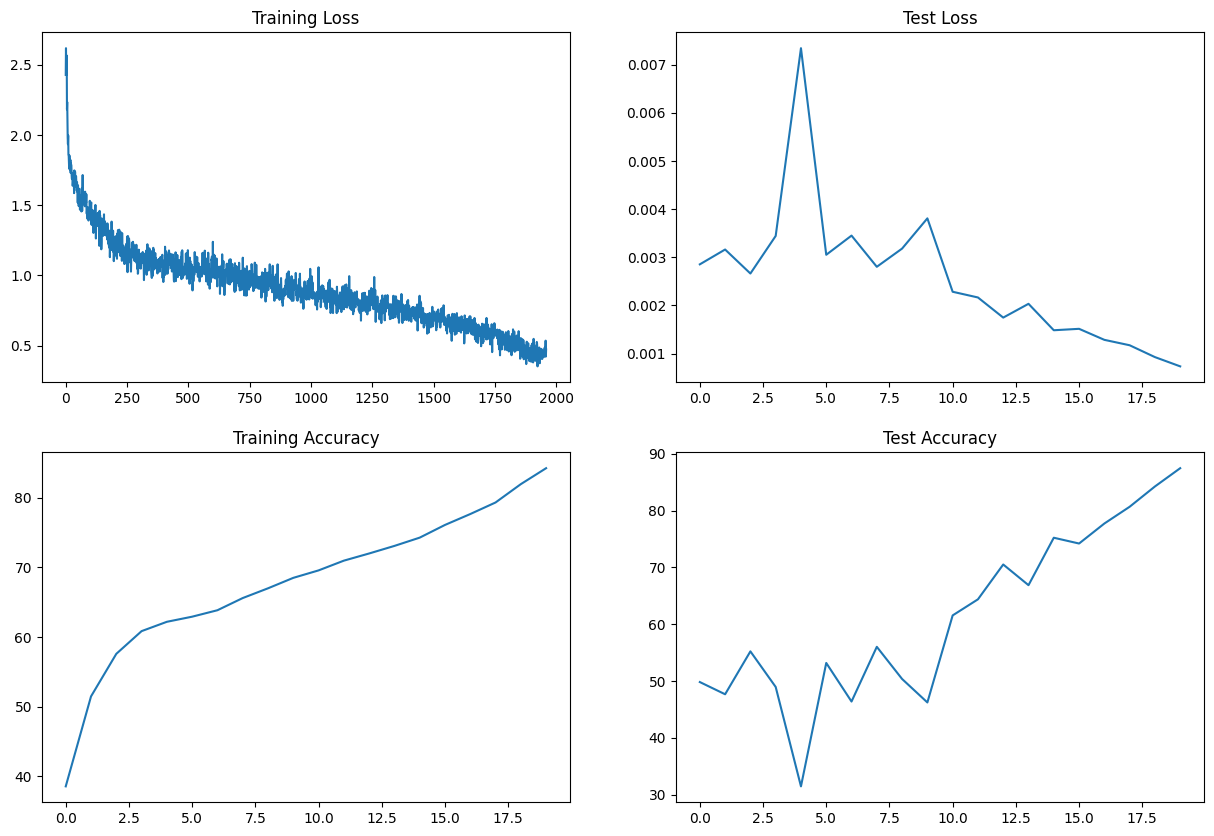

In [13]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

In [14]:
incorrect_examples, incorrect_labels,incorrect_pred = mis_classified_images(model, device, test_loader)

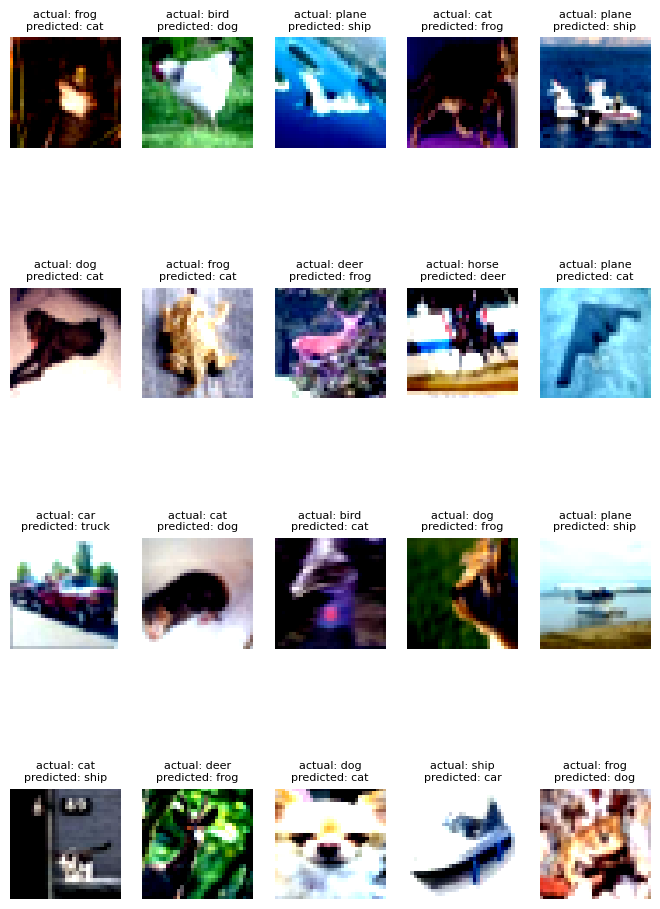

In [15]:
plot_images(incorrect_examples, incorrect_labels,incorrect_pred, num_images= 20)

In [16]:
## GRADCAM

In [17]:
# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
targets = None

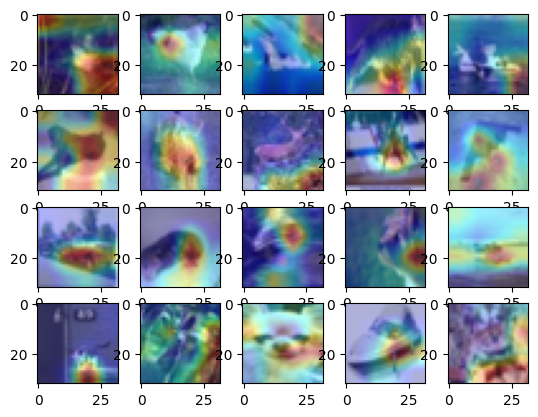

In [20]:
display_gradcam(model, incorrect_examples, 20, inv_normalize, 0.7)